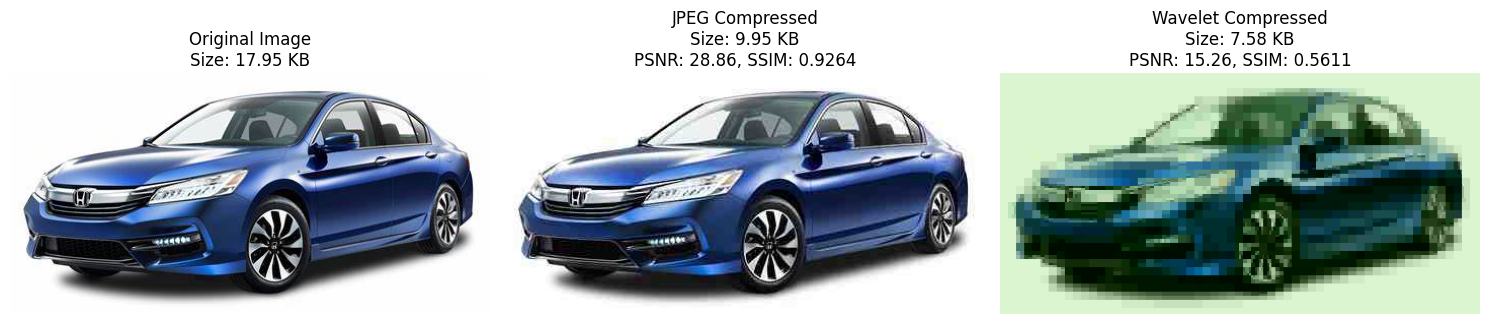

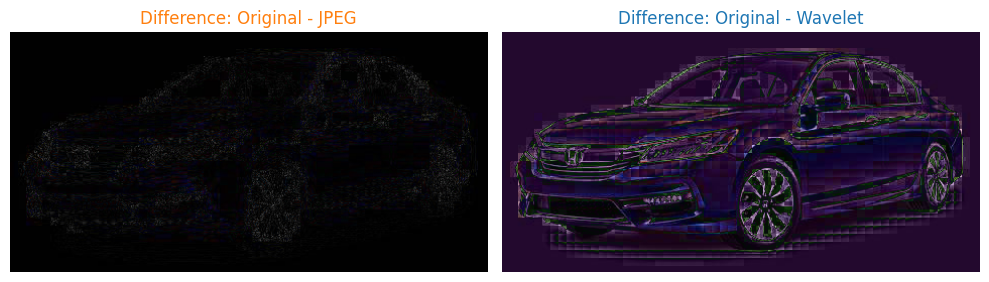

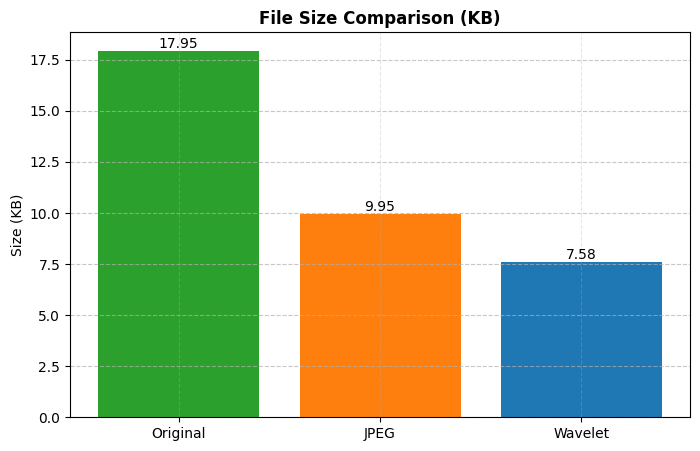

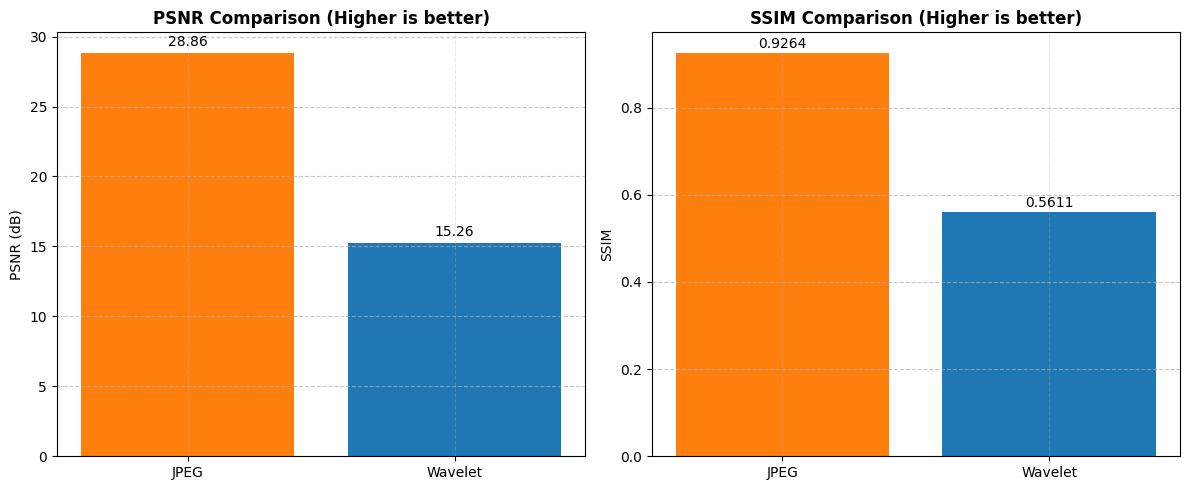

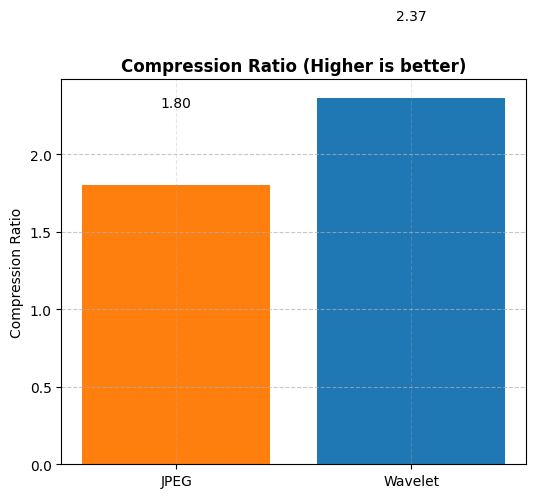


================ METRICS SUMMARY =================
Original Size: 17.95 KB
JPEG Size: 9.95 KB | PSNR: 28.86 | SSIM: 0.9264 | CR: 1.80
Wavelet Size: 7.58 KB | PSNR: 15.26 | SSIM: 0.5611 | CR: 2.37


In [ ]:
import cv2 
import numpy as np 
import pywt 
import matplotlib.pyplot as plt 
import os 
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 

# -------------------- Load Image -------------------- 
image_path = r"C:/Users/DELL/Desktop/DSP assignment/OIP.png" 
image = cv2.imread(image_path) 
if image is None: 
    raise FileNotFoundError(f"Image not found at {image_path}") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
original_size = os.path.getsize(image_path) / 1024  # in KB 

# -------------------- JPEG Compression -------------------- 
def jpeg_compress(img, quality=10, out_path='compressed_jpeg.jpg'): 
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality] 
    _, encimg = cv2.imencode('.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR), encode_param) 
    with open(out_path, 'wb') as f: 
        f.write(encimg.tobytes()) 
    compressed_img = cv2.imread(out_path) 
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB) 
    size = os.path.getsize(out_path) / 1024 
    return compressed_img, size 

# -------------------- Improved Wavelet Compression -------------------- 
def wavelet_compress(img, wavelet='haar', level=3, threshold_factor=0.1, out_path='compressed_wavelet.png'):
    # Convert to YCbCr color space (better for compression)
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    channels = cv2.split(img_ycbcr)
    
    compressed_channels = []
    for c in channels:
        # Wavelet transform
        coeffs = pywt.wavedec2(c, wavelet=wavelet, level=level)
        
        # Calculate threshold based on coefficient magnitudes
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        threshold = threshold_factor * np.max(np.abs(coeff_arr))
        
        # Threshold and quantize coefficients
        coeff_arr = pywt.threshold(coeff_arr, threshold, mode='soft')
        quant_step = threshold / 2  # More aggressive quantization
        coeff_arr = np.round(coeff_arr / quant_step) * quant_step
        
        # Convert back to wavelet coefficients structure
        coeffs_processed = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
        compressed_c = pywt.waverec2(coeffs_processed, wavelet)
        compressed_channels.append(compressed_c)
    
    # Reconstruct image
    compressed_img = cv2.merge(compressed_channels)
    compressed_img = np.clip(compressed_img, 0, 255).astype(np.uint8)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_YCrCb2RGB)
    
    # Save as PNG with maximum compression
    cv2.imwrite(out_path, cv2.cvtColor(compressed_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 9])
    size = os.path.getsize(out_path) / 1024
    
    return compressed_img, size

# -------------------- Compression -------------------- 
jpeg_img, jpeg_size = jpeg_compress(image, quality=25) 
wavelet_img, wavelet_size = wavelet_compress(image, level=3, threshold_factor=0.08) 

# Resize wavelet image if shape mismatch 
if wavelet_img.shape != image.shape: 
    wavelet_img = cv2.resize(wavelet_img, (image.shape[1], image.shape[0])) 

# -------------------- Metrics -------------------- 
def get_metrics(original, compressed): 
    psnr = peak_signal_noise_ratio(original, compressed) 
    ssim = structural_similarity(original, compressed, channel_axis=2) 
    return psnr, ssim 

jpeg_psnr, jpeg_ssim = get_metrics(image, jpeg_img) 
wavelet_psnr, wavelet_ssim = get_metrics(image, wavelet_img) 

jpeg_cr = original_size / jpeg_size 
wavelet_cr = original_size / wavelet_size 

# -------------------- Visualization Settings --------------------
# Manual styling configuration
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

colors = {
    'jpeg': '#FF7F0E',  # Orange
    'wavelet': '#1F77B4',  # Blue
    'original': '#2CA02C',  # Green
    'diff': '#D62728'  # Red
}

# -------------------- Image Comparison Plot --------------------
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image\nSize: {:.2f} KB".format(original_size))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(jpeg_img)
plt.title("JPEG Compressed\nSize: {:.2f} KB\nPSNR: {:.2f}, SSIM: {:.4f}".format(
    jpeg_size, jpeg_psnr, jpeg_ssim))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(wavelet_img)
plt.title("Wavelet Compressed\nSize: {:.2f} KB\nPSNR: {:.2f}, SSIM: {:.4f}".format(
    wavelet_size, wavelet_psnr, wavelet_ssim))
plt.axis("off")
plt.tight_layout()
plt.show()

# -------------------- Difference Images Plot --------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.absdiff(image, jpeg_img))
plt.title("Difference: Original - JPEG", color=colors['jpeg'])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.absdiff(image, wavelet_img))
plt.title("Difference: Original - Wavelet", color=colors['wavelet'])
plt.axis("off")
plt.tight_layout()
plt.show()

# -------------------- File Size Comparison --------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(['Original', 'JPEG', 'Wavelet'], 
               [original_size, jpeg_size, wavelet_size],
               color=[colors['original'], colors['jpeg'], colors['wavelet']])
plt.title("File Size Comparison (KB)", fontweight='bold')
plt.ylabel("Size (KB)")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# -------------------- Quality Metrics Comparison --------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['JPEG', 'Wavelet'], [jpeg_psnr, wavelet_psnr], 
        color=[colors['jpeg'], colors['wavelet']])
plt.title("PSNR Comparison (Higher is better)", fontweight='bold')
plt.ylabel("PSNR (dB)")
for i, v in enumerate([jpeg_psnr, wavelet_psnr]):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(['JPEG', 'Wavelet'], [jpeg_ssim, wavelet_ssim], 
        color=[colors['jpeg'], colors['wavelet']])
plt.title("SSIM Comparison (Higher is better)", fontweight='bold')
plt.ylabel("SSIM")
for i, v in enumerate([jpeg_ssim, wavelet_ssim]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# -------------------- Compression Ratio Comparison --------------------
plt.figure(figsize=(6, 5))
plt.bar(['JPEG', 'Wavelet'], [jpeg_cr, wavelet_cr], 
        color=[colors['jpeg'], colors['wavelet']])
plt.title("Compression Ratio (Higher is better)", fontweight='bold')
plt.ylabel("Compression Ratio")
for i, v in enumerate([jpeg_cr, wavelet_cr]):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# -------------------- Save Final Results -------------------- 
print(f"\n{' METRICS SUMMARY ':=^50}")
print(f"Original Size: {original_size:.2f} KB") 
print(f"JPEG Size: {jpeg_size:.2f} KB | PSNR: {jpeg_psnr:.2f} | SSIM: {jpeg_ssim:.4f} | CR: {jpeg_cr:.2f}") 
print(f"Wavelet Size: {wavelet_size:.2f} KB | PSNR: {wavelet_psnr:.2f} | SSIM: {wavelet_ssim:.4f} | CR: {wavelet_cr:.2f}") 

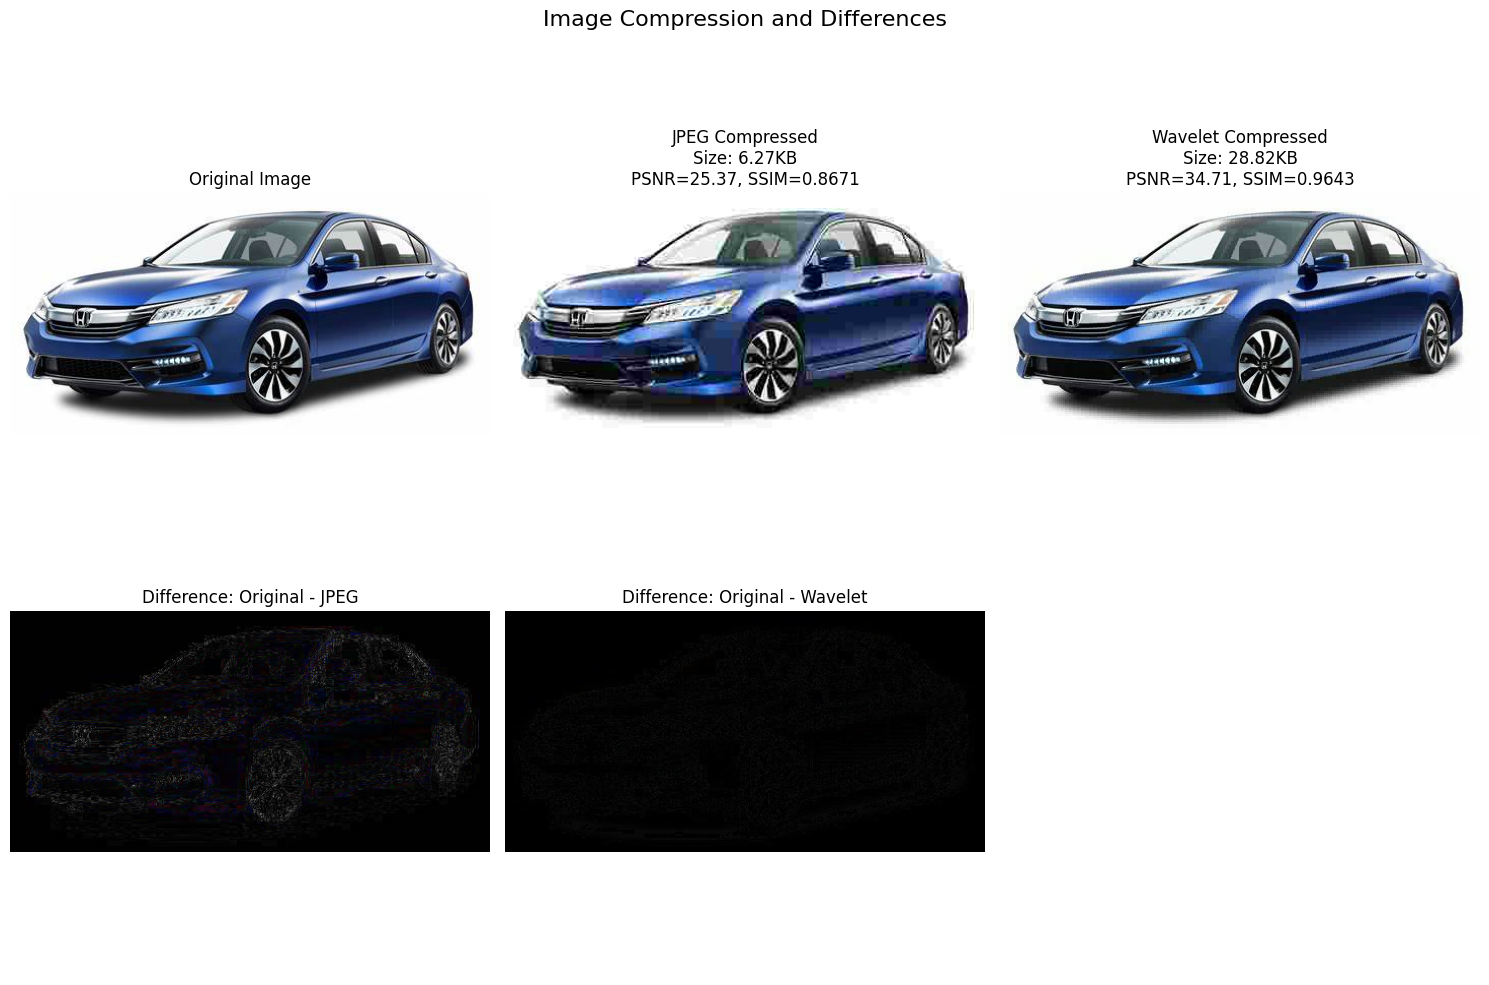

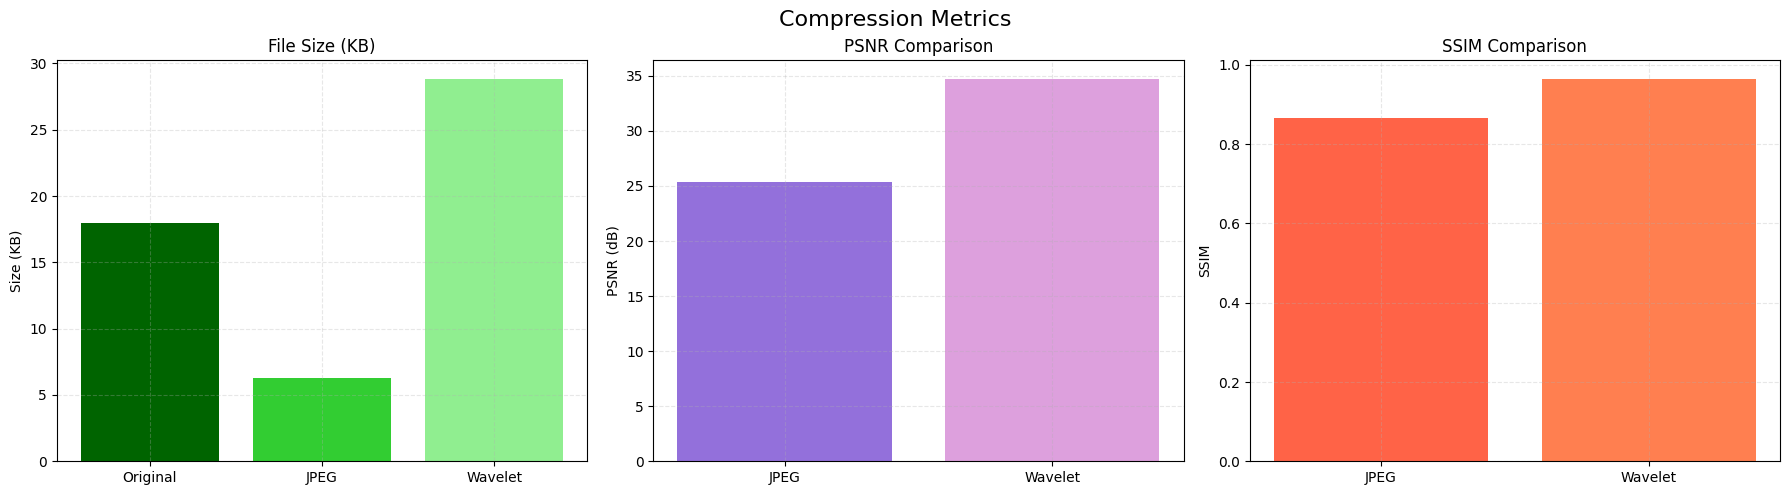

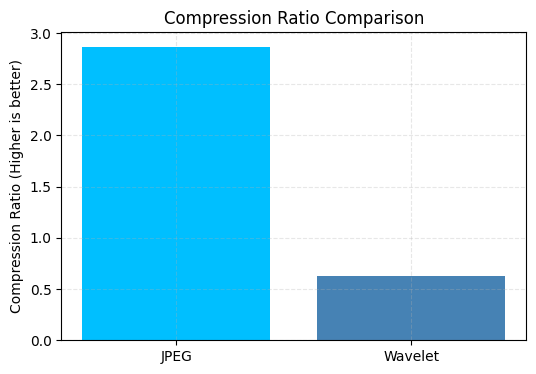

Original Size: 17.95 KB
JPEG Size: 6.27 KB | PSNR: 25.37 | SSIM: 0.8671 | CR: 2.86
Wavelet Size: 28.82 KB | PSNR: 34.71 | SSIM: 0.9643 | CR: 0.62


In [36]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------- Load Image --------------------
image_path = r"C:/Users/DELL/Desktop/DSP assignment/OIP.png"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = os.path.getsize(image_path) / 1024  # in KB

# -------------------- JPEG Compression --------------------
def jpeg_compress(img, quality=10, out_path='compressed_jpeg.jpg'):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR), encode_param)
    with open(out_path, 'wb') as f:
        f.write(encimg.tobytes())
    compressed_img = cv2.imread(out_path)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)
    size = os.path.getsize(out_path) / 1024
    return compressed_img, size

# -------------------- Improved Wavelet Compression --------------------
def wavelet_compress(img, wavelet='db1', level=3, threshold_factor=0.15, out_path='compressed_wavelet.jpg'):
    """
    Improved wavelet compression with proper quantization and size reduction
    
    Parameters:
        img: Input RGB image
        wavelet: Wavelet type (default 'db1')
        level: Decomposition level (default 3)
        threshold_factor: Fraction of coefficients to keep (default 0.15 = 15%)
        out_path: Output file path
    """
    # Convert to YCbCr color space (better for compression)
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    channels = cv2.split(img_ycbcr)
    
    compressed_channels = []
    for c in channels:
        # Wavelet decomposition
        coeffs = pywt.wavedec2(c, wavelet=wavelet, level=level)
        
        # Thresholding - keep only significant coefficients
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        # Keep only the top threshold_factor% of coefficients
        threshold = np.percentile(np.abs(coeff_arr), 100*(1-threshold_factor))
        coeff_arr = pywt.threshold(coeff_arr, threshold, mode='hard')
        
        # Reconstruct
        coeffs_thresh = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
        compressed_c = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
        compressed_channels.append(compressed_c)
    
    # Recombine channels and convert back to RGB
    compressed_img = np.stack(compressed_channels, axis=2)
    compressed_img = np.clip(compressed_img, 0, 255).astype(np.uint8)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_YCrCb2RGB)
    
    # Save with optimized JPEG compression
    cv2.imwrite(out_path, cv2.cvtColor(compressed_img, cv2.COLOR_RGB2BGR), 
                [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    
    size = os.path.getsize(out_path) / 1024  # in KB
    return compressed_img, size

# -------------------- Compression --------------------
jpeg_img, jpeg_size = jpeg_compress(image, quality=10)
wavelet_img, wavelet_size = wavelet_compress(image, threshold_factor=0.15)

# Resize wavelet image if shape mismatch (shouldn't be needed with improved version)
if wavelet_img.shape != image.shape:
    wavelet_img = cv2.resize(wavelet_img, (image.shape[1], image.shape[0]))

# -------------------- Metrics --------------------
def get_metrics(original, compressed):
    psnr = peak_signal_noise_ratio(original, compressed)
    ssim = structural_similarity(original, compressed, channel_axis=2)
    return psnr, ssim

jpeg_psnr, jpeg_ssim = get_metrics(image, jpeg_img)
wavelet_psnr, wavelet_ssim = get_metrics(image, wavelet_img)

jpeg_cr = original_size / jpeg_size
wavelet_cr = original_size / wavelet_size

# -------------------- Difference Images --------------------
diff_jpeg = cv2.absdiff(image, jpeg_img)
diff_wavelet = cv2.absdiff(image, wavelet_img)

# -------------------- Save images separately --------------------
output_dir = r"C:/Users/DELL/Desktop/DSP assignment/output_images"
os.makedirs(output_dir, exist_ok=True)

# Save compressed images
cv2.imwrite(os.path.join(output_dir, "jpeg_compressed.jpg"), cv2.cvtColor(jpeg_img, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(output_dir, "wavelet_compressed.jpg"), cv2.cvtColor(wavelet_img, cv2.COLOR_RGB2BGR))

# Save difference images (use PNG to avoid compression artifacts)
cv2.imwrite(os.path.join(output_dir, "difference_jpeg.png"), cv2.cvtColor(diff_jpeg, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(output_dir, "difference_wavelet.png"), cv2.cvtColor(diff_wavelet, cv2.COLOR_RGB2BGR))

# -------------------- Plot: Images --------------------
fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10))

axs1[0, 0].imshow(image)
axs1[0, 0].set_title("Original Image")
axs1[0, 0].axis("off")

axs1[0, 1].imshow(jpeg_img)
axs1[0, 1].set_title(f"JPEG Compressed\nSize: {jpeg_size:.2f}KB\nPSNR={jpeg_psnr:.2f}, SSIM={jpeg_ssim:.4f}")
axs1[0, 1].axis("off")

axs1[0, 2].imshow(wavelet_img)
axs1[0, 2].set_title(f"Wavelet Compressed\nSize: {wavelet_size:.2f}KB\nPSNR={wavelet_psnr:.2f}, SSIM={wavelet_ssim:.4f}")
axs1[0, 2].axis("off")

axs1[1, 0].imshow(diff_jpeg)
axs1[1, 0].set_title("Difference: Original - JPEG")
axs1[1, 0].axis("off")

axs1[1, 1].imshow(diff_wavelet)
axs1[1, 1].set_title("Difference: Original - Wavelet")
axs1[1, 1].axis("off")

axs1[1, 2].axis("off")  # Empty slot

plt.tight_layout()
plt.suptitle("Image Compression and Differences", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# -------------------- Plot: Graphs --------------------
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))

# File Size (KB)
axs2[0].bar(['Original', 'JPEG', 'Wavelet'], [original_size, jpeg_size, wavelet_size], color=['darkgreen', 'limegreen', 'lightgreen'])
axs2[0].set_title("File Size (KB)")
axs2[0].set_ylabel("Size (KB)")

# PSNR Comparison
axs2[1].bar(['JPEG', 'Wavelet'], [jpeg_psnr, wavelet_psnr], color=['mediumpurple', 'plum'])
axs2[1].set_title("PSNR Comparison")
axs2[1].set_ylabel("PSNR (dB)")

# SSIM Comparison
axs2[2].bar(['JPEG', 'Wavelet'], [jpeg_ssim, wavelet_ssim], color=['tomato', 'coral'])
axs2[2].set_title("SSIM Comparison")
axs2[2].set_ylabel("SSIM")

plt.tight_layout()
plt.suptitle("Compression Metrics", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

# -------------------- Plot: Compression Ratio --------------------
plt.figure(figsize=(6, 4))
plt.bar(['JPEG', 'Wavelet'], [jpeg_cr, wavelet_cr], color=['deepskyblue', 'steelblue'])
plt.title("Compression Ratio Comparison")
plt.ylabel("Compression Ratio (Higher is better)")
plt.show()

# -------------------- Print Summary --------------------
print(f"Original Size: {original_size:.2f} KB")
print(f"JPEG Size: {jpeg_size:.2f} KB | PSNR: {jpeg_psnr:.2f} | SSIM: {jpeg_ssim:.4f} | CR: {jpeg_cr:.2f}")
print(f"Wavelet Size: {wavelet_size:.2f} KB | PSNR: {wavelet_psnr:.2f} | SSIM: {wavelet_ssim:.4f} | CR: {wavelet_cr:.2f}")
